In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=1e03190f67b8739c8441947126eaf79f0aba1e7564212f15d549b8da04f0339d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

1. Using Spark MLlib build a model to predict taxi fare from trip distance (Model: M1)


In [4]:
#1
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Load the dataset
m1_data = spark.read.csv("/content/nyc_taxi.csv", header=True, inferSchema=True)

# Select features
m1_assembler = VectorAssembler(inputCols=["distance"], outputCol="features")
m1_data = m1_assembler.transform(m1_data)

# Initialize and fit the Linear Regression model
m1_lr = LinearRegression(labelCol="fare", featuresCol="features")
m1_lr_model = m1_lr.fit(m1_data)

2. Using Spark MLlib build a model to predict taxi fare from trip distance and trip duration in minutes (Model: M2)

In [5]:
from pyspark.sql.functions import col, concat, lit, to_timestamp

m2_data = spark.read.csv("/content/nyc_taxi.csv", header=True, inferSchema=True)
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# Concatenate and convert date and time columns to timestamp objects
m2_data = m2_data.withColumn("pickup_datetime", to_timestamp(concat(col("pickup_date"), lit(" "), col("pickup_time")),"MM/d/yyyy HH:mm"))
m2_data = m2_data.withColumn("dropoff_datetime", to_timestamp(concat(col("dropoff_date"), lit(" "), col("dropoff_time")), "MM/d/yyyy HH:mm"))

In [6]:
from pyspark.sql.types import IntegerType

# Calculate trip duration in minutes
m2_data_all = m2_data.withColumn("trip_duration_minutes", ((col("dropoff_datetime").cast("long") - col("pickup_datetime").cast("long")) / 60).cast(IntegerType()))

m2_data_all.show(5)

+-----------+-----------+------------+------------+--------+----+-----+-------------------+-------------------+---------------------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|    pickup_datetime|   dropoff_datetime|trip_duration_minutes|
+-----------+-----------+------------+------------+--------+----+-----+-------------------+-------------------+---------------------+
|   1/1/2017|       0:00|    1/1/2017|        0:00|    0.02| 0.0| 52.8|2017-01-01 00:00:00|2017-01-01 00:00:00|                    0|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.5| 0.0|  5.3|2017-01-01 00:00:00|2017-01-01 00:03:00|                    3|
|   1/1/2017|       0:00|    1/1/2017|        0:39|    7.75|4.66|27.96|2017-01-01 00:00:00|2017-01-01 00:39:00|                   39|
|   1/1/2017|       0:00|    1/1/2017|        0:06|     0.8|1.45| 8.75|2017-01-01 00:00:00|2017-01-01 00:06:00|                    6|
|   1/1/2017|       0:00|    1/1/2017|        0:08|     0.9| 0

In [7]:
# Select relevant columns including the calculated trip duration
m2_training_data = m2_data_all.select("distance", "trip_duration_minutes", "fare")

# Initialize and fit the Linear Regression model (M2)
m2_assembler = VectorAssembler(inputCols=["distance", "trip_duration_minutes"], outputCol="features")
m2_training_data = m2_assembler.transform(m2_training_data)

m2_lr = LinearRegression(labelCol="fare", featuresCol="features")
m2_lr_model = m2_lr.fit(m2_training_data)

2.1 What is the fare of a 20 mile long trip using M1

In [8]:
new_trip_distance = 20.0
new_trip_data = spark.createDataFrame([(new_trip_distance,)], ["distance"])
new_trip_data = m1_assembler.transform(new_trip_data)
predicted_fare = m1_lr_model.transform(new_trip_data).first().prediction

# Print the predicted fare
print(f"The predicted fare for a 20-mile using M1 trip is ${predicted_fare:.2f}")

The predicted fare for a 20-mile using M1 trip is $67.90


2.2 What is the fare of a 14 mile trip that took 75 minutes using M2

In [9]:
new_trip_distance = 14.0
new_trip_duration = 75.0
new_trip_data = spark.createDataFrame([(new_trip_distance, new_trip_duration)], ["distance", "trip_duration_minutes"])
new_trip_data = m2_assembler.transform(new_trip_data)
predicted_fare = m2_lr_model.transform(new_trip_data).first().prediction

# Print the predicted fare
print(f"The predicted fare for a 14-mile trip that took 75 minutes is ${predicted_fare:.2f} using M2")

The predicted fare for a 14-mile trip that took 75 minutes is $51.27 using M2


2.3 Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min?

In [10]:
# Predictions for the two scenarios
trip_1_distance = 10.0
trip_1_duration = 40.0

trip_2_distance = 13.0
trip_2_duration = 25.0

trip_1_data = spark.createDataFrame([(trip_1_distance, trip_1_duration)], ["distance", "trip_duration_minutes"])
trip_2_data = spark.createDataFrame([(trip_2_distance, trip_2_duration)], ["distance", "trip_duration_minutes"])

trip_1_data = m2_assembler.transform(trip_1_data)
trip_2_data = m2_assembler.transform(trip_2_data)

predicted_fare_1 = m2_lr_model.transform(trip_1_data).first().prediction
predicted_fare_2 = m2_lr_model.transform(trip_2_data).first().prediction

print("Predicted Fare for trip1 using M2",predicted_fare_1)
print("Predicted Fare for trip2 using M2",predicted_fare_2)

# Determine which fare is higher
if predicted_fare_1 > predicted_fare_2:
    print("The fare for the 10-mile trip taking 40 minutes is higher.")
elif predicted_fare_1 < predicted_fare_2:
    print("The fare for the 13-mile trip taking 25 minutes is higher.")
else:
    print("The fares for both scenarios are the same.")


Predicted Fare for trip1 using M2 38.35805763935095
Predicted Fare for trip2 using M2 47.68260649672519
The fare for the 13-mile trip taking 25 minutes is higher.


3. Using Spark operations (transformation and actions) compute the average tip amount

In [11]:
# Average tip amount
average_tip = m2_data_all.select("tip").agg({"tip": "avg"}).collect()[0][0]

# Print the average tip amount
print(f"The average tip amount is: ${average_tip:.2f}")


The average tip amount is: $1.70


4. During which hour the city experiences the most number of trips? E.g. 10am-11am or 4pm-5pm

In [12]:
from pyspark.sql.functions import hour

# Extracting hour from the pickup date and time
m2_data_all = m2_data_all.withColumn("pickup_hour", hour(m2_data_all["pickup_datetime"]))

#number of trips for each hour
hourly_trip_counts = m2_data_all.groupBy("pickup_hour").count().orderBy("pickup_hour")

# the hour with the highest number of trips
most_trips_hour = hourly_trip_counts.orderBy(hourly_trip_counts["count"].desc()).first()["pickup_hour"]
print(f"The city experiences the most number of trips during the hour {most_trips_hour}:00 - {most_trips_hour + 1}:00")

The city experiences the most number of trips during the hour 17:00 - 18:00


5. Compare Spark’s performance
Divide the data into 10 parts: 10%, 20%, …, 100%
Plot the time taken by each method

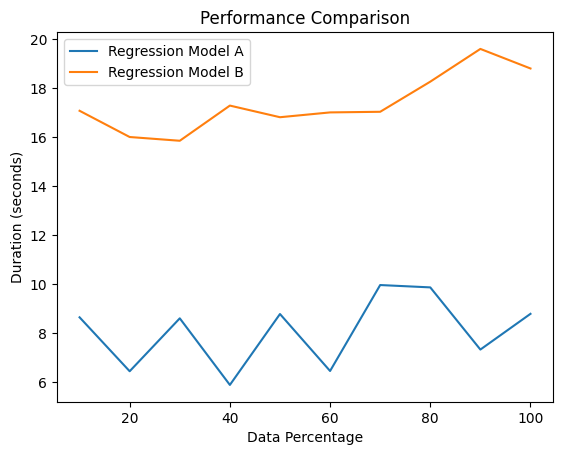

In [13]:
import time
import matplotlib.pyplot as plt

# Timing arrays for both models
duration_model_A = []
duration_model_B = []

# Evaluate for various data sizes from 10% to 100%
for data_fraction in range(10, 110, 10):

    # Sampling data for Model A
    sampled_A = m1_data.sample(fraction=data_fraction/100.0, seed=7)
    train_A, test_A = sampled_A.randomSplit([0.7, 0.3], seed=7)

    # Start timing Model A training
    start_A = time.time()

    # Feature extraction for Model A
    feature_assembler_A = VectorAssembler(inputCols=["distance"], outputCol="features_for_A")
    ready_train_A = feature_assembler_A.transform(train_A)
    ready_test_A = feature_assembler_A.transform(test_A)

    regression_A = LinearRegression(labelCol="fare", featuresCol="features_for_A")
    trained_A = regression_A.fit(ready_train_A)

    end_A = time.time()
    duration_model_A.append(end_A - start_A)

    # Sampling data for Model B
    sampled_B = m2_training_data.sample(fraction=data_fraction/100.0, seed=7)
    train_B, test_B = sampled_B.randomSplit([0.7, 0.3], seed=7)

    # Start timing Model B training
    start_B = time.time()

    # Feature extraction for Model B
    feature_assembler_B = VectorAssembler(inputCols=["distance", "trip_duration_minutes"], outputCol="features_for_B")
    ready_train_B = feature_assembler_B.transform(train_B)
    ready_test_B = feature_assembler_B.transform(test_B)

    regression_B = LinearRegression(labelCol="fare", featuresCol="features_for_B")
    trained_B = regression_B.fit(ready_train_B)

    end_B = time.time()
    duration_model_B.append(end_B - start_B)

# Visualization of the results
data_sizes = [x for x in range(10, 110, 10)]

plt.plot(data_sizes, duration_model_A, label="Regression Model A")
plt.plot(data_sizes, duration_model_B, label="Regression Model B")
plt.xlabel("Data Percentage")
plt.ylabel("Duration (seconds)")
plt.title("Performance Comparison")
plt.legend()
plt.show()